In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


Accuracy

$Accuracy = \dfrac{TP+TN}{P+N}= \dfrac{TP+TN}{(TP+TN)+(FP+FN)}$

Precision

$Precision = \dfrac{TP}{TP+FP}$

Recall (czułość)

$Recall = \dfrac{TP}{TP+FN}$

F1 score

$
F_1 = \dfrac{2}{\frac{1}{Recall}+\frac{1}{Precision}}
=\dfrac{2\times Precision \times Recall}{Precision+Recall}
=\dfrac{TP}{TP+\frac{1}{2}(FP+FN)}
$

In [25]:
diabetes = pd.read_csv('diabetes.csv')

features = diabetes.columns[1:9].to_list()
target = 'Diabetic'

X, y = diabetes[features], diabetes[target]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X[['Pregnancies','Age']], y, 
                                                    test_size=0.30, random_state=0,
                                                    stratify=y)
print('Treningowe obserwacje: %d\n Testowe informacje: %d' %(X_train.shape[0], X_test.shape[0]))

Treningowe obserwacje: 10500
 Testowe informacje: 4500


In [27]:
scaler_2var = StandardScaler()
# fit_transform() - on the trainning data, transform() - on the test data
# transform() acting on the test data uses the same mean and standard deviation as calculated from the trainning data
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

przyjęte modele

In [28]:
model_lr_00 = LogisticRegression()
model_lr_01 = LogisticRegression(penalty='l1', solver='saga', C=0.10, multi_class='auto')
model_lr_10 = LogisticRegression(penalty='l1', solver='saga', C=100, multi_class='auto')
model_lr_20 = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', multi_class='auto')


model_lr_00.fit(X_train_standardized, y_train)
model_lr_01.fit(X_train_standardized, y_train)
model_lr_10.fit(X_train_standardized, y_train)
model_lr_20.fit(X_train_standardized, y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [29]:
def plot_classification_surface(X_plot, y_plot, trained_model):
    plt.figure(figsize=(5,5))

    # określenie granic zbioru
    min1, max1 = X_plot[:,0].min()-1, X_plot[:,0].max()+1
    min2, max2 = X_plot[:,1].min()-1, X_plot[:,1].max()+1
    # (zakres przeskalowanej liczby ciąż i przeskalowanego wieku)

    # skalowanie dla obu osi
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, step=0.1)

    # utworzenie siatki
    xx, yy = np.meshgrid(x1grid, x2grid)

    # przetworzenie siatki w wektor
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1),1)), r2.reshape((len(r2),1))

    # stworzeniezmiennych objaśniających dla modelu
    grid = np.hstack((r1, r2))

    # predykcja modelu zbioru
    # przewidywania na stworzonej 'siatce' danych: liczby ciąż i wieku
    y_hat = trained_model.predict(grid)
    
    # przetworzenie predykcji na decyzje
    zz = y_hat.reshape(xx.shape)

    def visualization():
        # wizualizacja siatki z przyporządkowaną klasą
        plt.contourf(xx, yy, zz, cmap='Paired')

        # tworzenie wykresu punktowego dla kas ze zbioru X
        for class_value in range(2):
            
            # przyporządkowanie klasy (y) do obserwacji (X)
            row_ix = np.where(y_plot == class_value)
            
            # stworzenie wykresu punktowego
            plt.scatter(X_plot[row_ix,0], X_plot[row_ix,1], cmap='Paired', alpha=0.3, label=class_value)

        # wizualizacja wykresu
        plt.legend(loc='upper right')
        plt.show()

    visualization()

Ta sama procedura jak powyżej, scalona w jedną funkcję:

In [30]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure(figsize=(3,3))
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(3, 3))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    # metrics_dataframe = metrics_dataframe.concat({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
    #                                              ignore_index=True)
    # metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric})],
    #                                              ignore_index=True, axis=0)
    new_row = pd.DataFrame({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}, index=[0])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row])
    return metrics_dataframe

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



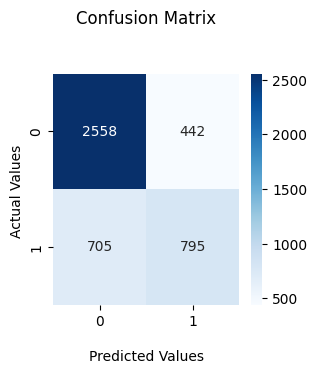

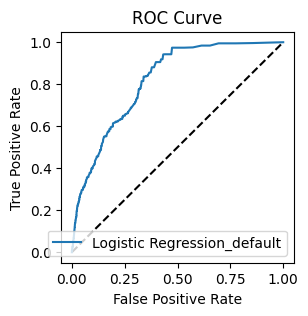

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.74      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.74      0.74      4500



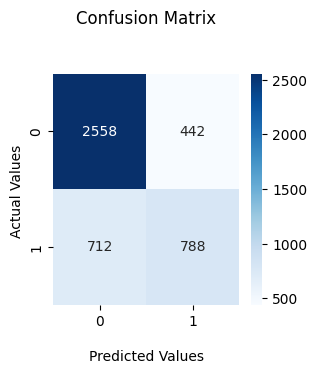

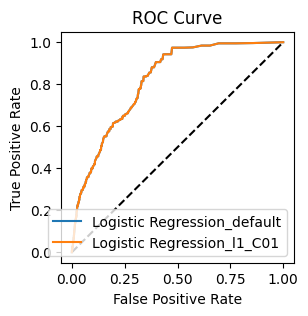

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



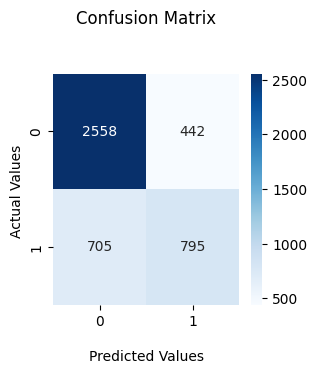

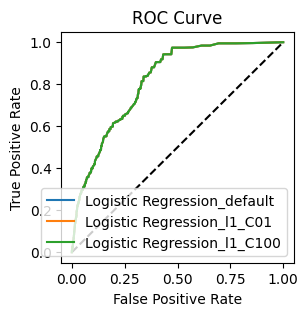

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



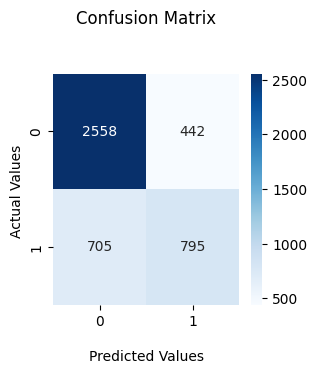

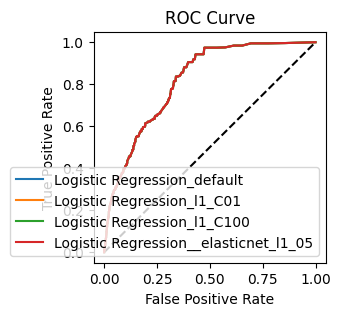

,Model,F1_score,AUC
0,Logistic Regression_default,0.580928,0.816493
0,Logistic Regression_l1_C01,0.577289,0.816494
0,Logistic Regression_l1_C100,0.580928,0.816493
0,Logistic Regression__elasticnet_l1_05,0.580928,0.816493


In [31]:
calculate_metrics(model_lr_00, 'Logistic Regression_default', X_test_standardized, y_test) 
calculate_metrics(model_lr_01, 'Logistic Regression_l1_C01', X_test_standardized, y_test) 
calculate_metrics(model_lr_10, 'Logistic Regression_l1_C100', X_test_standardized, y_test) 
calculate_metrics(model_lr_20, 'Logistic Regression__elasticnet_l1_05', X_test_standardized, y_test) 


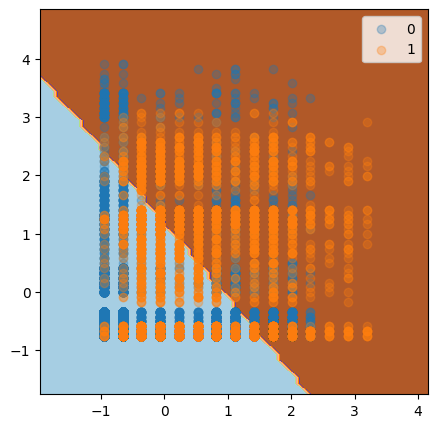

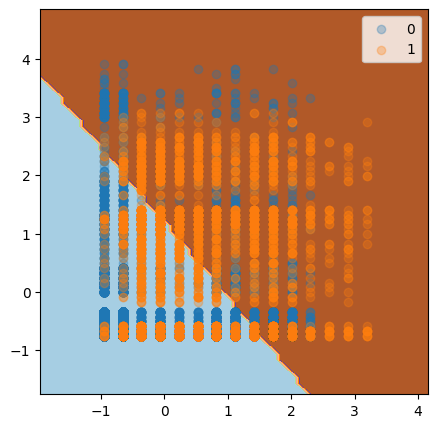

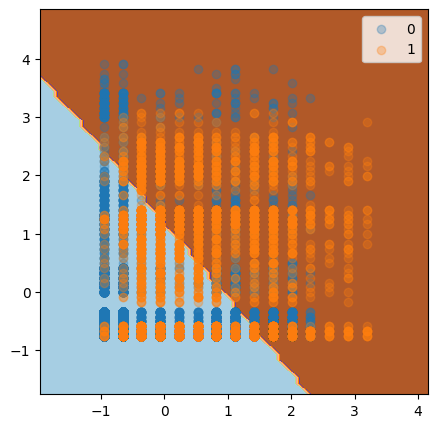

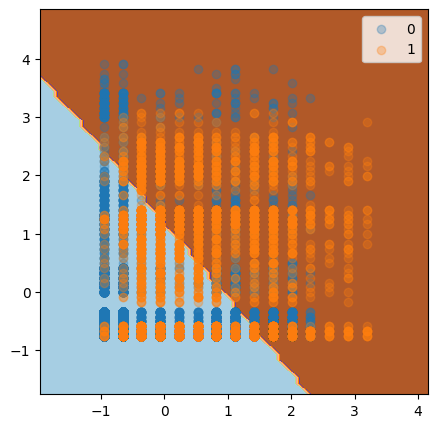

In [32]:
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_lr_00)
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_lr_01)
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_lr_10)
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_lr_20)


Wniosek: dla przyjętych zmiennych parametrów: funkcji kary l_1, l_2, elasticnet, 
odwrotności współczynnika siły regularyzacji C=0.1, 10 nie odnotowano różnic pomiędzy rozwiązaniami. 